In [34]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from camera_intrinsic import mtx

# Standard Variablen

In [35]:
depth_image_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\Tiefenkarten\20241214_125237_staerke7_DepthMap.tiff"
rgb_image_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\TestBilder\20241214_125237_staerke7.jpg"

#Images
depth_im = Image.open(depth_image_url)  # Quelle: https://stackoverflow.com/a/67346474
rgb_im = Image.open(rgb_image_url)
rgb_im = ImageOps.exif_transpose(rgb_im)  # the picture will be rotated when opening based on the EXIF metadata. transpose stops that.


# print(depth_min, depth_max)
# print(depth_array)  # ggf. herausfinden, in welcher einheit die Entfernung angegeben ist (cm, mm, etc. ?) -> vermutlich cm?

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB imae to that size.

In [36]:
rgb_width, rgb_height = rgb_im.size
dm_width, dm_height = depth_im.size  # width and height of depth map image. 

print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image

size = (dm_width, dm_height)  # define new size
rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image

rgb_width, rgb_height = rgb_im.size
print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")

dm_height:1008, dm_width:566
 rgb_height:4032, rgb_width:2268
new_rgb_height:1008, new_rgb_width:566


Getting the images as numpy arrays for later use

In [37]:
depth_array = np.array(depth_im)  # getting the depthmap as a numpy array
rgb_array = np.array(rgb_im)  # getting the rgb image as a numpy array

We need the images as open3d objects or else we can´t create the RGBD image

In [38]:
# convert the arrays to open3d objects Quelle: https://stackoverflow.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array
rgb_o3d = o3d.geometry.Image(rgb_array)
depth_o3d = o3d.geometry.Image(depth_array)
depth_3d = o3d.geometry.Image(np.ascontiguousarray(depth_array))

# Visualizing depth map

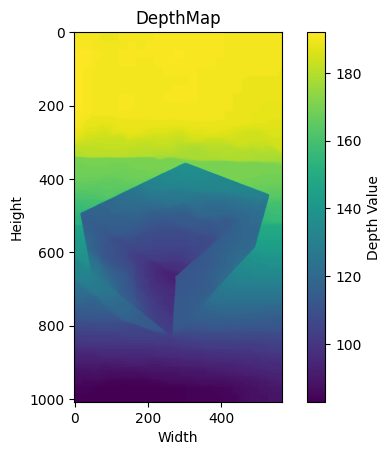

In [39]:
depth_im = Image.open(depth_image_url)  # Quelle: https://stackoverflow.com/a/67346474
dm_width, dm_height = depth_im.size  # width and height of depthmap image

depth_array = np.array(depth_im)  # getting the depthmap as a numpy array

# plotting the depthmap
plt.imshow(depth_array)
plt.colorbar(label="Depth Value")
plt.title("DepthMap")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


# Create RGBD image

In [40]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d)  # Quelle:https://www.open3d.org/docs/latest/python_api/open3d.geometry.RGBDImage.html und https://stackoverflo.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array

Comparison of RGB and depth map image

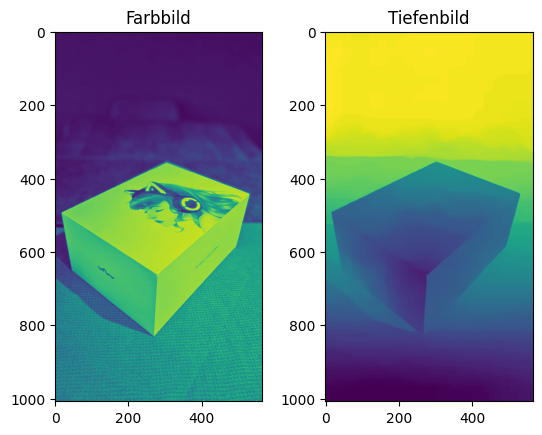

In [41]:
plt.subplot(1, 2, 1)
plt.title("Farbbild")
plt.imshow(rgbd.color)
plt.subplot(1, 2, 2)
plt.title("Tiefenbild")
plt.imshow(rgbd.depth)
plt.show()

#Creating point cloud

With the intrinsics of the camera that took the photo we are able to correct verkrümmungen 

In [42]:
#TODO: note that these are intrinsics from the opencv sample images. i  need to replace them with my intrinsics!
intrinsic = o3d.camera.PinholeCameraIntrinsic(dm_width, dm_height,
                                              mtx[0][0],  # fx
                                              mtx[1][1],  # fy
                                              mtx[0][2],  # cx
                                              mtx[1][2])  # cy

## Point cloud only from depth image

In [43]:
#depth image von uint8 zu uint16, da sonst die Funktion "o3d.geometry.PointCloud.create_from_depth_image" nicht funktioniert. Quelle: https://www.open3d.org/docs/latest/python_api/open3d.geometry.PointCloud.html
depth_data_uint16 = (depth_array.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d = o3d.geometry.Image(depth_data_uint16)

# Erstelle eine Point Cloud aus dem Tiefenbild
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_uint16_o3d,
    intrinsic
)

In [44]:
o3d.visualization.draw_geometries([pcd])

## Point cloud only from RGBD image

In [76]:
pcrgbd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
o3d.visualization.draw_geometries([pcrgbd])

In [101]:
downpcd = pcrgbd.voxel_down_sample(voxel_size=0.000005)
o3d.visualization.draw_geometries([downpcd])

In [102]:
print(downpcd)

PointCloud with 35931 points.


In [103]:
#Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [104]:
print("Statistical oulier removal")
cl, ind = downpcd.remove_statistical_outlier(nb_neighbors=100,
                                                    std_ratio=2.0)
display_inlier_outlier(downpcd, ind)


Statistical oulier removal
Showing outliers (red) and inliers (gray): 


In [ ]:
#TODO: point cloud bereinigen (richtige methode finden)